In [1]:
######################
# So you want to train a Neural CDE model?
# Let's get started!


import math
import torch
import torchcde
from get_data import *
from dataloader import *
from test_function import *
from tqdm import tqdm
#from NN_classes import *
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(device)

cpu


In [2]:
######################
# A CDE model looks like

class CDEFunc(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, hidden_width=128):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.hidden_width  = hidden_width

        self.linear1 = torch.nn.Linear(hidden_channels, self.hidden_width)
        self.linear2 = torch.nn.Linear(self.hidden_width, input_channels * hidden_channels)

    ######################
    # For most purposes the t argument can probably be ignored; unless you want your CDE to behave differently at
    # different times, which would be unusual. But it's there if you need it!
    ######################
    def forward(self, t, z):
        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        z = self.linear2(z)
        ######################
        # Easy-to-forget gotcha: Best results tend to be obtained by adding a final tanh nonlinearity.
        ######################
        # try without?        
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z


######################
# Next, we need to package CDEFunc up into a model that computes the integral.
######################
class NeuralCDE(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, hidden_width, output_channels, interpolation="cubic"):
        super(NeuralCDE, self).__init__()

        self.func = CDEFunc(input_channels, hidden_channels, hidden_width)
        self.initial = torch.nn.Linear(input_channels, hidden_channels)
        self.readout = torch.nn.Linear(hidden_channels, output_channels)
        self.interpolation = interpolation

    def forward(self, coeffs):
        if self.interpolation == 'cubic':
            X = torchcde.CubicSpline(coeffs)
        elif self.interpolation == 'linear':
            X = torchcde.LinearInterpolation(coeffs)
        else:
            raise ValueError("Only 'linear' and 'cubic' interpolation methods are implemented.")

        ######################
        # Easy to forget gotcha: Initial hidden state should be a function of the first observation.
        ######################
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)

        ######################
        # Actually solve the CDE.
        ######################
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.func
                              ,t=X.interval, adjoint=False, backend='torchdiffeq',atol = 1e-4, rtol = 1e-4)#, options=dict(jump_t=X.grid_points),)
                                #method='rk4', 
                                #options=dict(step_size=2e-4),
                                
                                #adjoint=False, atol = 1e-4, rtol = 1e-4)

        ######################
        # Both the initial value and the terminal value are returned from cdeint; extract just the terminal value,
        # and then apply a linear map.
        ######################
        z_T = z_T[:, 1]
        pred_y = self.readout(z_T)
        return pred_y




torch.Size([400, 550, 4])
torch.Size([280, 450, 4])
19  timessteps done
39  timessteps done
59  timessteps done
79  timessteps done
99  timessteps done
119  timessteps done
139  timessteps done
159  timessteps done
179  timessteps done
199  timessteps done
219  timessteps done
239  timessteps done
259  timessteps done
279  timessteps done
299  timessteps done
319  timessteps done
339  timessteps done
359  timessteps done
379  timessteps done
399  timessteps done
419  timessteps done
439  timessteps done
459  timessteps done
479  timessteps done
499  timessteps done
Error first half:  0.000629940163764435
Error second half:  0.0012294693995344034


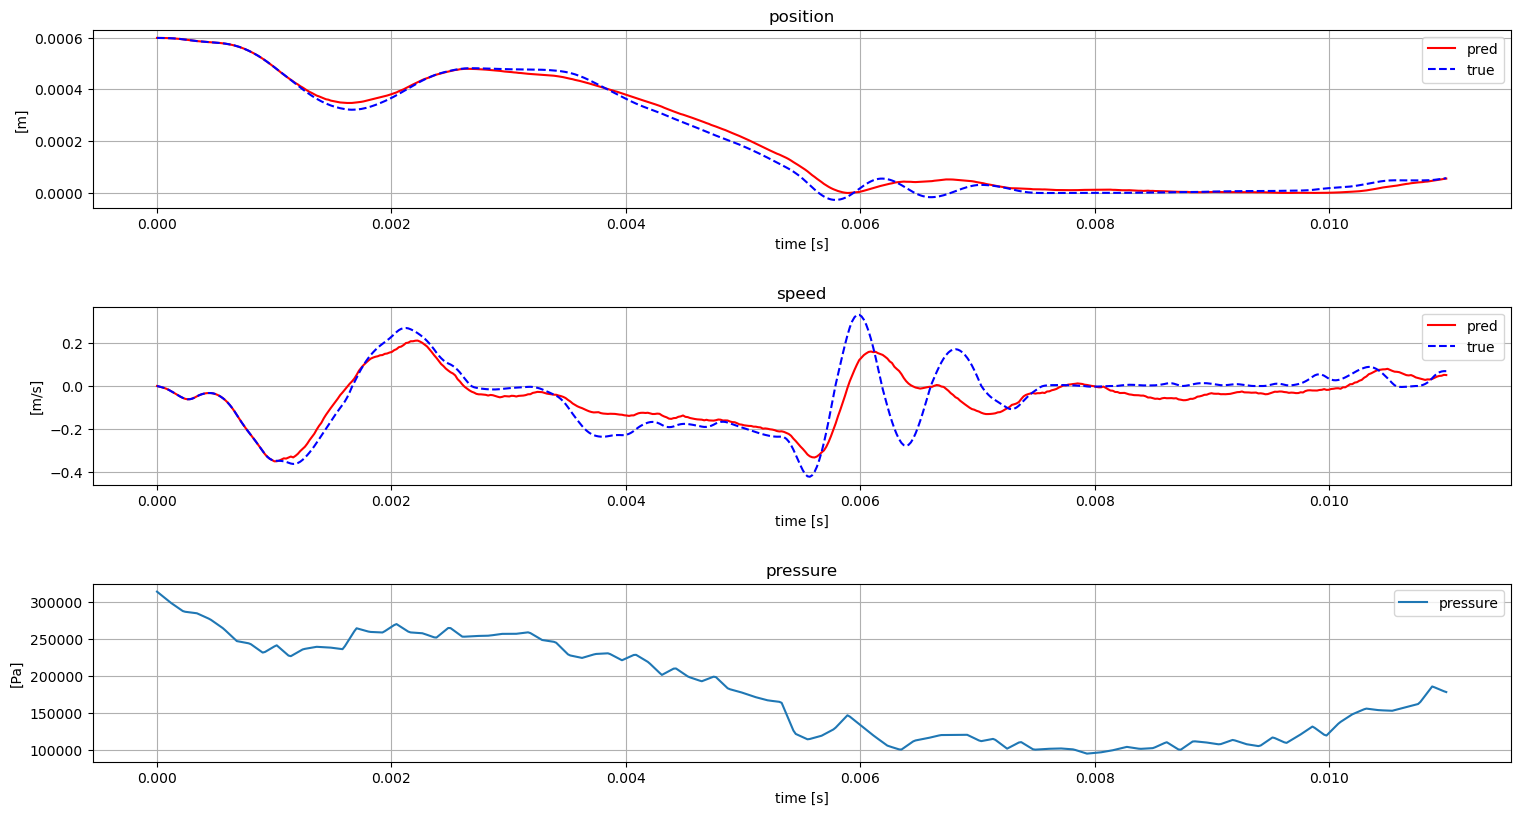

Test loss (MSE over whole Traj.): 0.000989657705226416


In [3]:
#Testing

path = "Ventil_trained_NNs\cde0.pth"

paramsliste = [       
                     {
                        "experiment_number" : 0,
                        "window_size" : 50,
                        "h_size" : 8,
                        "h_width" : 128,
                        "batch_size" : 500,
                        "learning_rate" : 0.000,
                        "part_of_data" : 0, 
                        "percentage_of_data" : 0.7,
                        "batch_size" : 2,
                        "cut_off_timesteps" : 100,
                        "drop_half_timesteps": True
                      }
                    ]

for params in paramsliste:

   # Generate input data (the data is normalized and some timesteps are cut off)
    input_data1, PSW_max = get_data_cde(path = "data\save_data_test_revised.csv", 
                            timesteps_from_data=0, 
                            skip_steps_start = 0,
                            skip_steps_end = 0, 
                            drop_half_timesteps = params["drop_half_timesteps"],
                            normalise_s_w="minmax",
                            rescale_p=False,
                            num_inits=params["part_of_data"])
    
    input_data2, PSW_max = get_data_cde(path = "data\save_data_test5.csv", 
                            timesteps_from_data=0, 
                            skip_steps_start = 0,
                            skip_steps_end = 0, 
                            drop_half_timesteps = params["drop_half_timesteps"],
                            normalise_s_w="minmax",
                            rescale_p=False,
                            num_inits=params["part_of_data"])
    
    input_data3, PSW_max = get_data_cde(path = "data\Testruns_from_trajectory_generator_t2_t6_revised.csv", 
                            timesteps_from_data=0, 
                            skip_steps_start = 0,
                            skip_steps_end = 0, 
                            drop_half_timesteps = params["drop_half_timesteps"],
                            normalise_s_w="minmax",
                            rescale_p=False,
                            num_inits=params["part_of_data"])
    
    input_data = torch.cat((input_data1, input_data2, input_data3)).to(device)
    input_data = input_data1
    #cols = time_cols, pb_cols, sb_cols, wb_cols
    print(input_data.size())
        #Split data into train and test sets
    np.random.seed(1234)
    num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
    train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
    test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
    np.random.shuffle(train_inits)
    np.random.shuffle(test_inits)
    train_data = input_data[train_inits,:input_data.size(dim=1)-params["cut_off_timesteps"],:]
    test_data = input_data[test_inits,:,:]
    print(train_data.size())

    train_set = CustomDataset_cde(train_data, window_size=params["window_size"])
    train_loader = DataLoader(train_set, batch_size=params["batch_size"])  
    if device == "cuda:0":
        train_loader = DataLoader(train_set, batch_size=params["batch_size"], pin_memory=True)  

    model = NeuralCDE(input_channels=4, hidden_channels=params["h_size"], hidden_width = params["h_width"], output_channels=2).to(device)
    model.load_state_dict(torch.load(path, map_location=torch.device(device)))

           
    test_loss, test_loss_deriv, err_test = test(test_data.to(device), model, model_type = "neural_cde", window_size=params["window_size"], 
                                                display_plots=True, num_of_inits = 1, set_rand_seed=False, physics_rescaling = PSW_max)
    print('Test loss (MSE over whole Traj.): {}'.format(err_test.item()))



